# Содержание
- [1. Загрузка данных и подготовка их к анализу](#1)
    - [1.1 Загрузим и подготовим данные](#2)
    - [1.2 Вывод по качеству данных](#3)
- [2. Изучим и проверим данные](#4)
    - [2.1  Изучим события](#5)
    - [2.2  Определим временные границы](#6)
    - [2.3  Проверим качество распределения пользователей и событий по группам](#7)
    - [2.4  Вывод по проверке данных](#8)
- [3  Изучим воронку событий](#9)
    - [3.1  Анализ данных в разрезе отдельных событий](#10)
    - [3.2  Воронка продажи](#11)
- [4  Изучим результаты эксперимента](#12)
    - [4.1  А/А эксперимент](#13)
    - [4.2  Самое популярное событие во всех группах](#14)
    - [4.3  А1/В эксперимент](#15)
    - [4.4  А2/В эксперимент](#16)
    - [4.5  А1+А2/В эксперимент](#17)
    - [4.6  Вывод после попарных сравнений](#18)
    - [4.7  Множественные сравнения](#19)
- [5  Общий вывод](#20)

# Исследование поведения пользователей в мобильном приложении и анализ результатов А/А/В-эксперимента

Цель - разобраться в поведении пользователей нашего мобильного приложения по продажам продуктов питания. После исследовать результаты А/А/В эксперимента по изменению шрифтов во всем приложении

Задачи:
- Подготовим данные к анализу и изучим их
- Изучим воронку продаж - узнаем как пользователи доходят до покупки, сколько пользователей доходит, а сколько "застревает" и на каких этапах
- Изучим данные А/А/В теста на наличие ошибок и не качественных данных и интерпретируем результаты эксперимента

Перед началом работы, выведем все функции которые понадобятся нам для работы

In [1]:
#Определим функцию для вывода всей информации о данных в таблице
def inf_data(df):
    print('Первые 10 строк таблицы')
    display(df.head(10))
    pd.set_option('display.max_columns', None)
    print('----------')
    
    print('Общая информация о таблице')
    df.info()
    print('----------')
    
    print('Выведем наименование колонок')
    display(df.columns)
    print('----------')
    
    print('Посмотрим на типы данных')
    display(df.dtypes)
    print('----------')
    
    print('Проверим присутствуют ли пропуски в данных')
    display(df.isna().sum())
    print('----------')
    
    if df.duplicated().sum() == 0:
        print('Явных дубликатов нет')
    else:
        print('В наших данных {} записи являются дубликатами'.format(len(data[data.duplicated()])))
        display(df[df.duplicated()].head())

In [2]:
#Импортируем все необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from plotly import graph_objects as go
import math as mth

In [3]:
#Определим функцию настройки внешнего вида графиков
def plt_view(xlabel, ylabel, title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Загрузка данных и подготовка их к анализу
<a id='1'></a>

### Загрузим и подготовим данные
<a id='2'></a>

In [4]:
#Откроем и изучим наши данные
try:
    data = pd.read_csv('logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [5]:
inf_data(data)

Первые 10 строк таблицы


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


----------
Общая информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
----------
Выведем наименование колонок


Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

----------
Посмотрим на типы данных


EventName         object
DeviceIDHash       int64
EventTimestamp     int64
ExpId              int64
dtype: object

----------
Проверим присутствуют ли пропуски в данных


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

----------
В наших данных 413 записи являются дубликатами


,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248


В таблице собраны данные о событиях совершенных пользователями мобильного приложения о продаже продуктов питания:
- название события
- идентификатор пользователя
- время совершения события
- информация к какой группе относится пользователь - 246 и 247 - контрольная группа, а 248 - экспериментальная, которой показывалось приложение с полностью измененными шрифтами.

Что необходимо исправить в данных:
- Сразу бросается в глаза неудачное наименование колонок.
- В колонке со временем совершения события не верный тип данных и поэтому не верный вывод значений.

В данных нет пропусков, однако присутствуют явные дубликаты. Так как не может быть такого, чтобы один и тот же человек в одно и то же время совершил одно и то же событие - от дублирующих строк нужно избавится, чтобы они не искажали наши результаты. Сначала удалим дубликаты, а после будем исправлять данные

In [6]:
#Перед удалением посмотрим процент потери в данных
print('Процент потери данных при удалении дубликатов {0:.2%}'.format(len(data[data.duplicated()])/len(data)))

Процент потери данных при удалении дубликатов 0.17%


In [7]:
#Сохраним изначальный размер нашей таблицы
#для дальнейшего понимания общих потерь данных
data_orig_size = len(data)

Так как процент потери максимально низкий спокойно удаляем дублирующие строки

In [8]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Наши данные готовы для дальнейших изменений

In [9]:
#Корректируем наименование столбцов
data.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
data.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

In [10]:
#Корректируем тип данных даты совершения события
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.dtypes

event_name                 object
user_id                     int64
event_timestamp    datetime64[ns]
exp_id                      int64
dtype: object

In [11]:
#Тип поменялся, теперь посмотрим как выводится значение времени
data.head()

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Так как нам даны полные значения времени совершения события - и дата и время - то дополнительно выделим значения только дня совершения события

In [12]:
data['event_date'] = data['event_timestamp'].dt.strftime('%Y-%m-%d')
data.head()

,event_name,user_id,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Вывод по качеству данных
<a id='3'></a>

При общем изучении данных нашли 413 дублирующих строк, которые были удалены. Также нами были переименованы столбцы и значения даты совершения события были приведены к верному типу и виду. И выделили в отдельный столбец непосредственно день совершения события.

Наши данные подготовлены к дальнейшему изучению

## Изучим и проверим данные
<a id='4'></a>

### Изучим события
<a id='5'></a>

Посмотрим общие данные о событиях:
- общее количество событий,
- общее количество пользователей,
- а также сколько в среднем событий приходится на пользователя

In [13]:
print(
    'Общее количество событий в логе - {}'
      .format(data['event_name'].count())
)
print()
print(
    'Общее количество пользователей в логе - {}'
      .format(data['user_id'].nunique())
)
print()
print(
    'На одного пользователя в среднем приходится {0:.0f} события'
    .format(data['event_name'].count()/data['user_id'].nunique())
)

Общее количество событий в логе - 243713

Общее количество пользователей в логе - 7551

На одного пользователя в среднем приходится 32 события


### Определим временные границы
<a id='6'></a>

In [14]:
#Найдем временные рамки сбора данных
print('Начало сбора данных - {}, окончание - {}'
      .format(data['event_timestamp'].min(), data['event_timestamp'].max()))

Начало сбора данных - 2019-07-25 04:43:36, окончание - 2019-08-07 21:15:17


Теперь мы знаем, что самое первое событие зафиксировалось 25 июля 2019 года в 4:43 утра, а самое последнее - 7 августа 2019 года в 21:15 вечера.
Посмотрим на распределение фиксирования событий во всем диапазоне времени

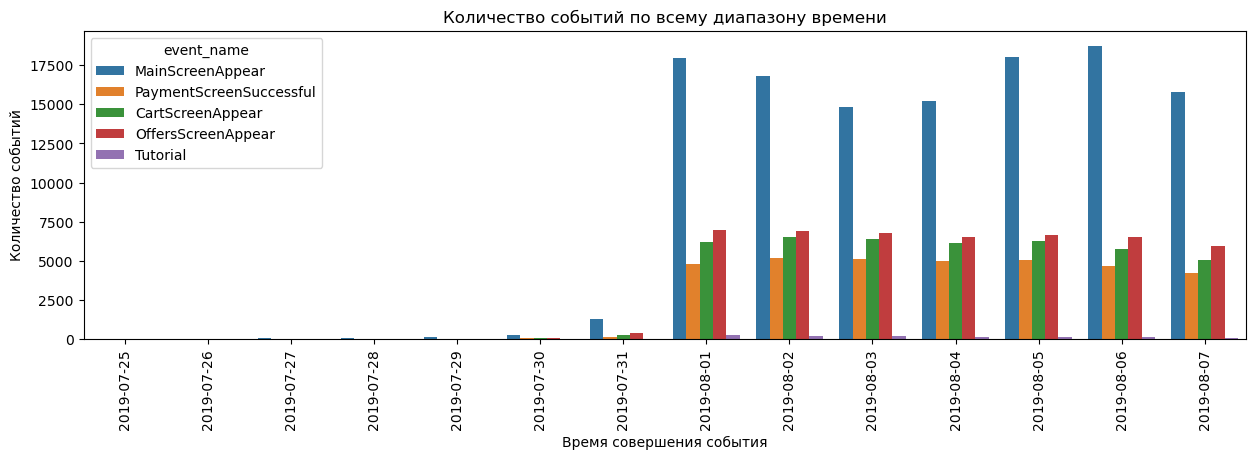

In [15]:
plt.figure(figsize=(15, 4))
sns.countplot(x=data['event_date'], hue='event_name', data=data)
plt.xticks(rotation=90)
plt_view('Время совершения события',
         'Количество событий', 
         'Количество событий по всему диапазону времени')

Видим большую разницу в значениях после 1 августа 2019 года. Посмотрим на распределение значений до этой даты

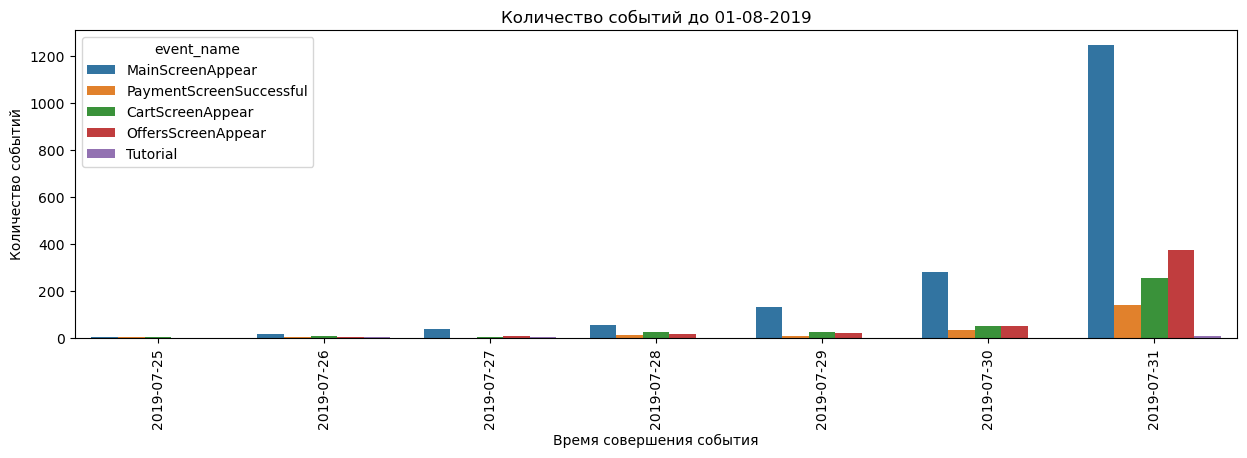

In [16]:
plt.figure(figsize=(15, 4))
sns.countplot(x=data.query('event_timestamp < "2019-08-01"')['event_date'], hue='event_name', data=data)
plt.xticks(rotation=90)
plt_view('Время совершения события',
         'Количество событий', 
         'Количество событий до 01-08-2019')

Хоть и данные начали собирать с 25 июля 2019 года, данные по всем событиям полностью начали поступать примерно с 31 июля 2019 года. Скорее всего первые 6 дней происходил "закуп" пользователей, либо тестирование сбора данных. Найдем примерное время начала полного сбора данных 31 июля.

<AxesSubplot:>

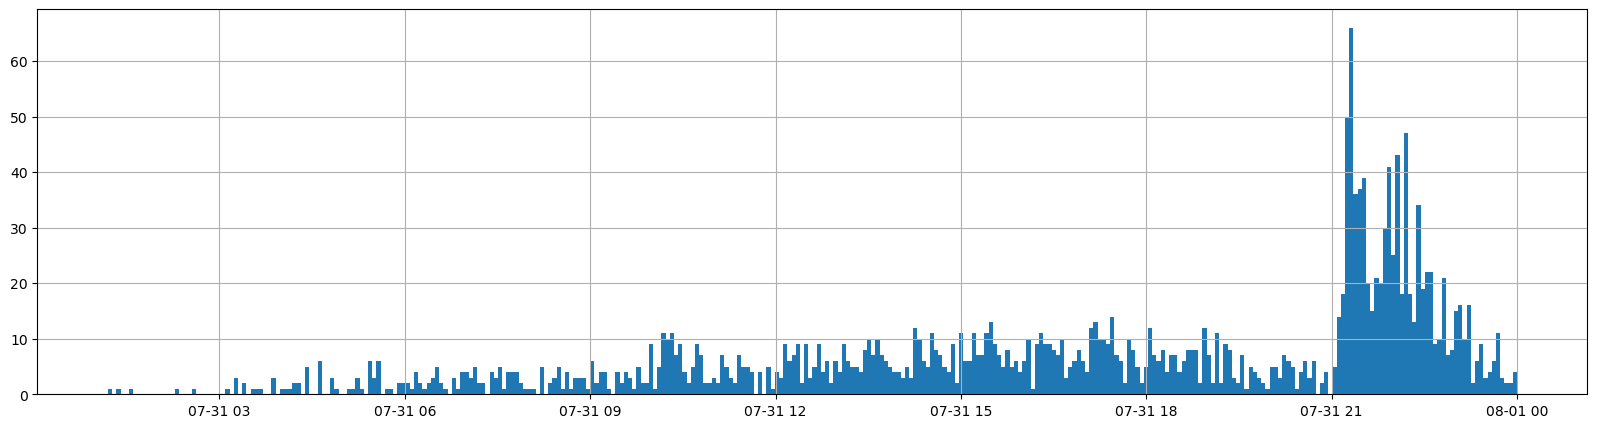

In [17]:
data.query('"2019-07-31" < event_timestamp < "2019-08-01"')['event_timestamp'].hist(bins=14*24, figsize=(20,5))

И тут мы видим резкий скачек в поступлении данных примерно с 21:00 31 июля 2019 года. Посмотрим на долю событий совершенных до этого времени

In [18]:
print('Доля событий до 21:00 31 июля 2019 года - {0:.2%}'
      .format(len(data.query('event_timestamp < "2019-07-31 21:00:00"')) / len(data)))

Доля событий до 21:00 31 июля 2019 года - 0.82%


До 31.07.2019 происходил сбор не полных данных и доля этих данных ничтожно мала (всего 0,82%). Однако необходимо еще оценить долю потерь отдельно по каждому событию и по уникальным пользователям

In [19]:
#Посмотрим на долю потерь данных относительно каждого события
df = data.query('event_timestamp < "2019-07-31 21:00:00"').groupby('event_name').agg({'user_id':'count'})
df['perc'] = df['user_id']/data.groupby('event_name').agg({'user_id':'count'})['user_id']*100
df

,user_id,perc
event_name,,
CartScreenAppear,325,0.761695
MainScreenAppear,1212,1.017624
OffersScreenAppear,277,0.591779
PaymentScreenSuccessful,167,0.489478
Tutorial,8,0.785855


In [20]:
#Доля потерь уникальных пользователей
print('Доля уникальных пользователей до 31 июля 2019 года - {0:.2%}'
      .format(data.query('event_timestamp < "2019-07-31 21:00:00"')['user_id'].nunique()/len(data)))

Доля уникальных пользователей до 31 июля 2019 года - 0.54%


При удалении данных собранных до 31.07.2019 в каждом событии мы теряем от 0,49 до 1.02 % данных, а также всего 0,54% уникальных пользователей. Все эти потери не более 1%, соотвественно мы можем не использовать данные за этот период, а полагаться лишь на полные данные.

In [21]:
data_good = data.query('event_timestamp >= "2019-07-31 21:00:00"').reset_index(drop=True)

In [22]:
#Найдем актуальные временные рамки анализируемых данных
print('Начало сбора данных - {}, окончание - {}'
      .format(data_good['event_timestamp'].min(), data_good['event_timestamp'].max()))

Начало сбора данных - 2019-07-31 21:00:57, окончание - 2019-08-07 21:15:17


Теперь границы нашего временного диапазона с 21:00 31 июля 2019 по 7 августа 2019 гг.

### Проверим качество распределения пользователей и событий по группам
<a id='7'></a>

In [23]:
exp_user = data_good.groupby('exp_id').agg({'user_id':['count', 'nunique']})
exp_user.columns = ['count_event', 'count_user']
exp_user['perc_event'] = round(exp_user['count_event'] / exp_user['count_event'].sum()*100, 2)
exp_user['perc_user'] = round(exp_user['count_user'] / exp_user['count_user'].sum()*100, 2)
exp_user

,count_event,count_user,perc_event,perc_user
exp_id,,,,
246,79556,2484,32.91,32.95
247,77293,2517,31.98,33.39
248,84875,2537,35.11,33.66


Мы видим, что в каждой группе (и контрольных и эксприментальной) присутствуют примерно равное количество пользователей (в контрольных около 33%, в экспериментальной - около 34%) и даже событий (в контрольных группах 32-33% событий, в экспериментальтной - около 35%).

### Вывод по проверке данных
<a id='8'></a>

В процессе проверки данных мы выяснили, что нам подходит для анализа не весь представленный изначально диапазон времени (итоговый диапазон времени - с 31 июля 2019 по 07 августа 2019). Поэтому итоговая таблица немного сократилась. Оценим полные потери в данных

In [24]:
print('Процент потери данных после всех изменений - {0:.2%}'
     .format(1 - len(data_good) / data_orig_size))

Процент потери данных после всех изменений - 0.98%


По итогу мы потеряли около 1% данных - это ничтожно мало и соотвественно качество наших данных не пострадало и их вполне достаточно для дальнейшего изучения и анализа.

Выведем итоговые общие количества событий и пользователей в логе

In [25]:
print(
    'Общее количество событий в логе - {}'
      .format(data_good['event_name'].count())
)
print()
print(
    'Общее количество пользователей в логе - {}'
      .format(data_good['user_id'].nunique())
)

Общее количество событий в логе - 241724

Общее количество пользователей в логе - 7538


## Изучим воронку событий
<a id='9'></a>

Изучим события более детально:
- как часто встречается каждое событие
- сколько пользователей совершило каждое событие
- какой порядок перехода по событиям
- какая доля пользователей переходит с этапа на этап и где больше всего теряем
- какая доля изначальных пользователей доходит до оплаты.

### Анализ данных в разрезе отдельных событий
<a id='10'></a>

Посмотрим из каких событий состоят действия пользователей в наше мобильном приложении

In [26]:
data_good['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear', 'Tutorial'],
      dtype=object)

Действия пользователей разделены на 5 событий:
- MainScreenAppear - пользователь на главной странице (главный экран)
- PaymentScreenSuccessful - экран с успешной оплатой (экран совершения оплаты)
- CartScreenAppear - пользователь на экране с корзиной продуктов (экран корзины)
- OffersScreenAppear - пользователь на странице оффера (экран предложений)
- Tutorial - пользователь просматривает руководство пользователя (руководство)

In [27]:
#Найдем, как часто встречается каждое из этих событий
data_good['event_name'].value_counts().reset_index()

,index,event_name
0,MainScreenAppear,117889
1,OffersScreenAppear,46531
2,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


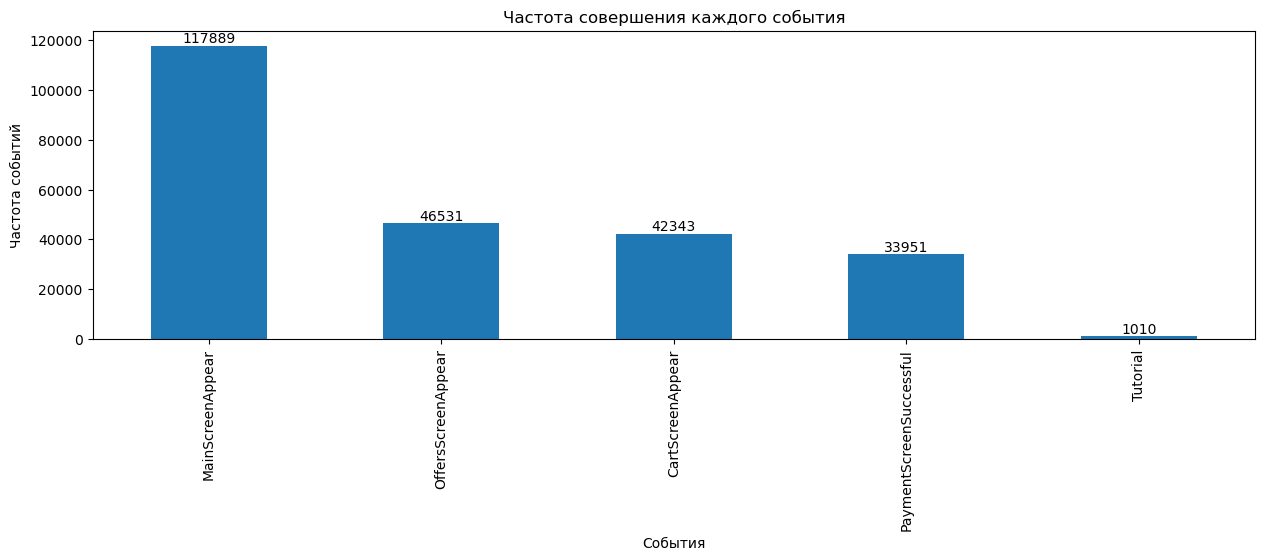

In [28]:
plt.figure(figsize=(15, 4))
ax = data_good['event_name'].value_counts().plot.bar()
for p in ax.patches:
    ax.annotate(
        "%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )
plt_view('События',
         'Частота событий', 
         'Частота совершения каждого события')

*Самое частое событие* - когда пользователь смотрит на *главную страницу*, что логично при посещении любого мобильного приложения. *Самое редкое событие* - экран с *руководством пользователя* - действительно на данную страницу переходят редко - только при наличии вопросов. Данный экран не является важным для прибыльности, ведь переход на него лишь косвенно влияет на совершении оплаты заказа - при условии, что пользователю не понятен алгоритм работы в приложении из-за чего у него возникли сложности с оформлением заказа.

In [29]:
#Оценим сколько пользователей совершило каждое событие
print('Общее количество пользователей - {}'
      .format(data_good['user_id'].nunique()))
print()
print('Распределение пользователей по событиям:')
data_good_user_event = (
    data_good.groupby('event_name')
    .agg({'user_id':'nunique'})
    .sort_values(by='user_id', ascending=False)
)

#Доля пользователей, которые хоть раз совершали событие
data_good_user_event['perc_user_event'] = round(
    data_good_user_event['user_id'] / data_good['user_id'].nunique()*100, 2
)
data_good_user_event

Общее количество пользователей - 7538

Распределение пользователей по событиям:


,user_id,perc_user_event
event_name,,
MainScreenAppear,7423,98.47
OffersScreenAppear,4597,60.98
CartScreenAppear,3736,49.56
PaymentScreenSuccessful,3540,46.96
Tutorial,843,11.18


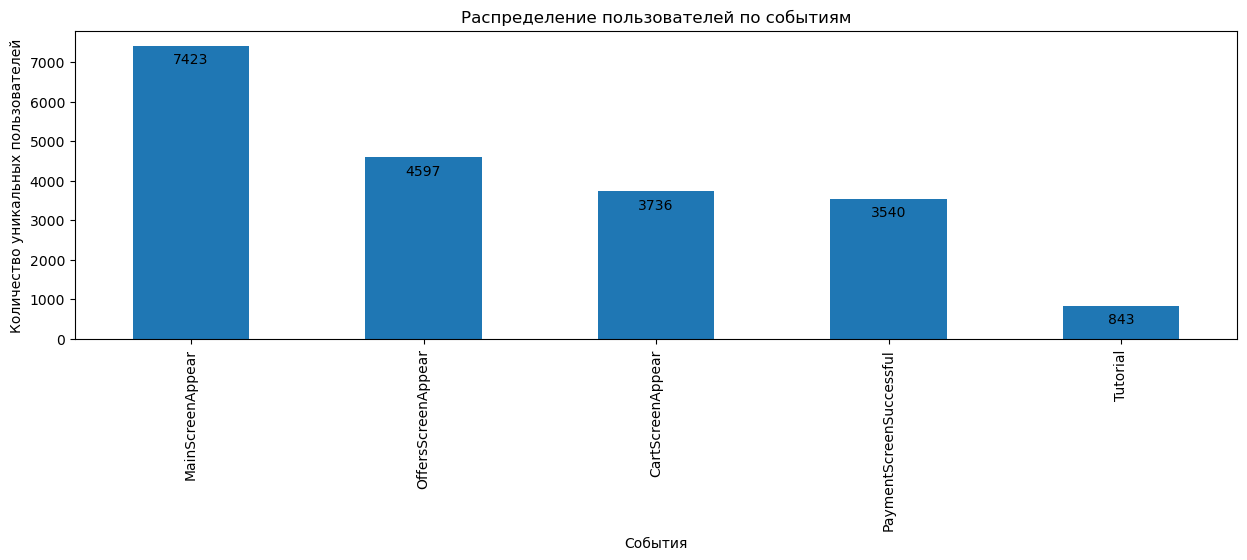

In [30]:
plt.figure(figsize=(15, 4))
ax = data_good_user_event['user_id'].plot.bar()
for p in ax.patches:
    ax.annotate(
        "%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, -10), textcoords='offset points'
    )
plt_view('События',
         'Количество уникальных пользователей', 
         'Распределение пользователей по событиям')

Больше всего пользователей (7423) видело главный экран, но так как их число не равно числу общего количества пользователей, можем предоложить, что не все пользователи изначально переходят на главный экран приложения.

На втором месте по посещениеям (4597 пользователей) - экран с предложениями.

Далее по посещениям идут экраны корзины (3736 пользователей) и успешной оплаты(3540 пользователей).

Меньше всего пользователей (843) просматривает руководство пользователя.


Как мы видим, распределение пользователей по событиям происходит в той же последовательности, что и распределение частоты совершения событий. Из этого мы можем предположить порядок совершения событий:
1. MainScreenAppear - пользователь открывает главный экран приложения, затем
2. OffersScreenAppear - в каталогах выбирает продукты, потом
3. CartScreenAppear - складывает товары в корзину и просматривает их непосредственно в ней и в итоге
4. PaymentScreenSuccessful - оплачивает товары.

Так как экран с руководством пользователя просматривают меньше всего пользователей и его посещение непосредственно не влияет на факт успешной оплаты - исключим его именно из воронки продажи.

### Воронка продажи
<a id='11'></a>

In [31]:
#Сохраним нашу таблицу без данных о событии "Tutorial"
data_good_user_event_prod = data_good_user_event[data_good_user_event.index != 'Tutorial']

In [32]:
#Расчитаем процент пользователей относительно прошлого этапа
data_good_user_event_prod['perc_previous'] = round(
    data_good_user_event_prod['user_id']/data_good_user_event_prod['user_id'].shift(1)*100, 2
)
data_good_user_event_prod

C:\Users\Home\AppData\Local\Temp\ipykernel_6532\66399462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_good_user_event_prod['perc_previous'] = round(


,user_id,perc_user_event,perc_previous
event_name,,,
MainScreenAppear,7423,98.47,NaN
OffersScreenAppear,4597,60.98,61.93
CartScreenAppear,3736,49.56,81.27
PaymentScreenSuccessful,3540,46.96,94.75


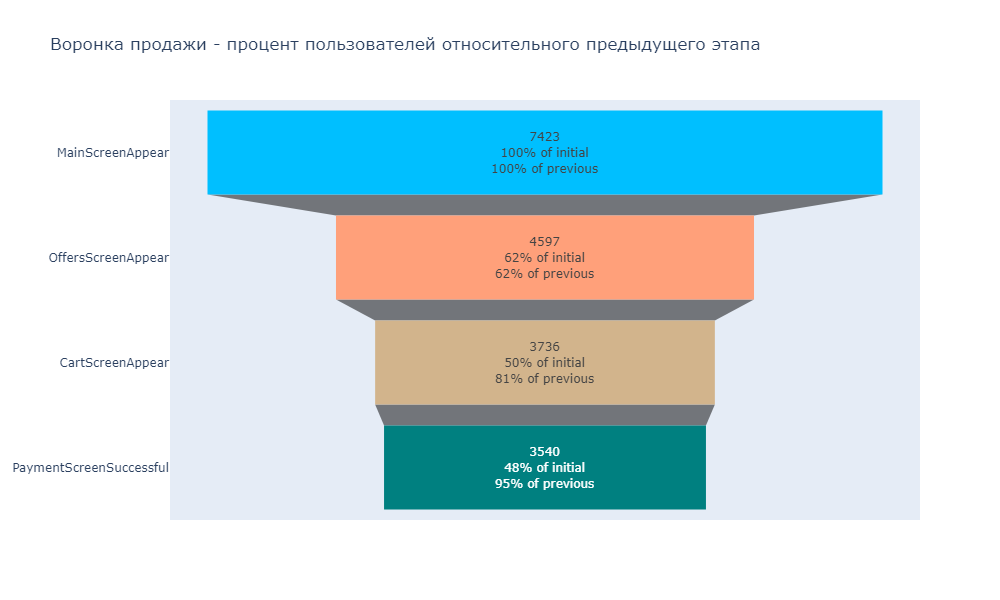

In [33]:
#Построим воронку по переходам пользователей от шага к шагу
#с процентным оотношением от шага к шагу, чтобы понять
#какой процент пользователей проходит на след этап
#относительно предыдущего
fig = go.Figure(
    go.Funnel(y = data_good_user_event_prod.index,
              x = data_good_user_event_prod['user_id'],
              marker = {"color": ['deepskyblue', 'lightsalmon', 'tan', 'teal']},
              textposition = "inside",
              textinfo = "value+percent previous+percent initial")
)
fig.update_layout(
    title='Воронка продажи - процент пользователей относительного предыдущего этапа')
fig.show(renderer='png', width=1000, height=600, scale=None)

Мы видим, что больший процент потери пользователей (38%) происходит при переходе с главного экрана приложения на экран предложения офферов. Это достаточно большой процент потери заинтересованности - возможно:
- присутствует какая то техническая проблема связанная с переходом с главного экрана на экран выбора товаров связанных с определенными мобильными устройствами либо не связанными с ними,
- либо не интуитивно понятный интерфейс главного экрана, что осложняет переход с него на экран выбора товаров - в связи с этим и потребность пользователей заходить на экран руководства пользователя.

В дальнейшем большая часть пользователей "остается с нами":
- 81% от пользователей выбирающих продукты в каталогах - складывают товары в корзину
- 95% пользователей, сформировавших корзину - совершают успешную покупку

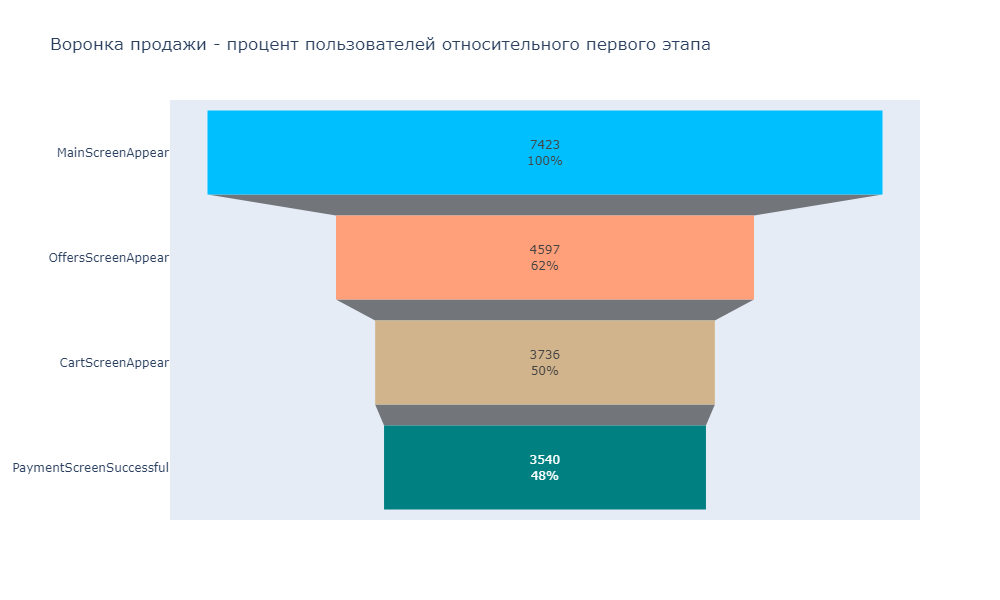

Процент пользователей, дошедших от первого события до оплаты - 47.69%


In [34]:
#Построим воронку по переходам пользователей от шага к шагу
#с процентным оотношением к первому шагу,
#чтобы понять сколько пользователей от изначального количества
#поэтапно доходит до успешной оплаты
fig = go.Figure(
    go.Funnel(y = data_good_user_event_prod.index,
              x = data_good_user_event_prod['user_id'],
              marker = {"color": ['deepskyblue', 'lightsalmon', 'tan', 'teal']},
              textposition = "inside",
              textinfo = "value+percent initial")
)
fig.update_layout(
    title='Воронка продажи - процент пользователей относительного первого этапа')
fig.show(renderer='png', width=1000, height=600, scale=None)
print('Процент пользователей, дошедших от первого события до оплаты - {0:.2%}'
      .format(
          data_good_user_event_prod['user_id'].min()/data_good_user_event_prod['user_id'].max()
      )
     )

50% посетителей главного экрана приложения доходят до просмотра сформированной корзины и практически все из них (48%) доходят до успешной оплаты.

## Изучим результаты эксперимента
<a id='12'></a>

Так как мы определили, что событие просмотра руководства пользователя нам не особо важно, то для изучения результатов эксперимента будем анализировать данные без него. Определим количество пользователей в каждой группе для каждого события. Но перед этим заменим цифровые наименования групп эксперимента на буквенные - вместо 246, 247 и 248 зададим А1, А2 и В соответственно

In [35]:
#Создадим функцию, которая будет возвращать буквенное обозначение эксперимента
def exp_cat(exp):
    if exp == 246:
        return "A1"
    if exp == 247:
        return "A2"
    return "B"

#Добавим новый столбец в наши данные с буквенным обозначением эксперимента
data_good['group'] = data_good['exp_id'].apply(exp_cat)

In [36]:
#Проверим правильность замены
data_good.head(10)

,event_name,user_id,event_timestamp,exp_id,event_date,group
0,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31,A2
1,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31,A2
2,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31,B
3,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31,A2
4,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31,B
5,MainScreenAppear,929387516286850088,2019-07-31 21:05:35,248,2019-07-31,B
6,OffersScreenAppear,3511569580412335882,2019-07-31 21:06:12,246,2019-07-31,A1
7,OffersScreenAppear,3511569580412335882,2019-07-31 21:07:16,246,2019-07-31,A1
8,MainScreenAppear,7701922487875823903,2019-07-31 21:07:27,247,2019-07-31,A2
9,OffersScreenAppear,5039418296347449582,2019-07-31 21:07:34,246,2019-07-31,A1


In [37]:
#Теперь оставим лишь данные по 4 событиям (из 5) и
#определим количество пользователей в каждой группе для каждого события
data_succes = (
    data_good.query('event_name != "Tutorial"').reset_index(drop=True)
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .reset_index()
)
data_succes = data_succes.sort_values(by='A1', ascending=False).reset_index(drop=True)
data_succes['A1+A2'] = data_succes[['A1', 'A2']].sum(axis=1)
data_succes

group,event_name,A1,A2,B,A1+A2
0,MainScreenAppear,2450,2479,2494,4929
1,OffersScreenAppear,1542,1524,1531,3066
2,CartScreenAppear,1266,1239,1231,2505
3,PaymentScreenSuccessful,1200,1158,1182,2358


In [38]:
#И определим общее количество пользователей в каждой группе
data_good_prod = (
    data_good.query('event_name != "Tutorial"').reset_index(drop=True)
    .pivot_table(index='group', values='user_id', aggfunc='nunique').T
)
data_good_prod['A1+A2'] = data_good_prod['A1'] + data_good_prod['A2']
data_good_prod

group,A1,A2,B,A1+A2
user_id,2483,2516,2535,4999


Так же необходимо проверить, что каждый пользователь попал лишь в одну исследуемую группу

In [39]:
data_good.query('event_name != "Tutorial"').groupby('user_id').agg({'group':'nunique'}).query('group > 1')

,group
user_id,


Действительно во всех группах нет повторяющихся пользователей.

Необходимо проверить результаты А/А/В эксперимента - исследование влияния замены шрифтов во всем приложении. Пользователи были разделены на 3 группы:
- 246 и 247 - контрольные - с изначальными шрифтами (А1 и А2)
- 248 - экспериментальная - с измененными шрифтами (В)

Проверять будем с помощью z-теста (проверка гипотезы о равенстве долей - сравнение пропорций двух генеральных совокупностей по выборкам из них)

Сравниваем выборки для каждого события - количество пользователей в группе и количество пользоватейлей события в группе

**Сформулируем гипотезы**:

*Нулевая гипотеза* - Нет статистически значимой разницы между группами

*Альтернативная гипотеза* - Существует существенная разница между пропорциями в группах

In [40]:
#Создадим функцию для работы z-теста
#для проверки равенства пропорций групп

def z_test(group1, group2, event, alpha):

    #успешное
    successes = np.array(
        [data_succes[data_succes['event_name']==event][group1],
         data_succes[data_succes['event_name']==event][group2]]
    )
    #общее
    trials = np.array(
        [data_good_prod[group1],
         data_good_prod[group2]]
    )

    #пропорция успехов в первой группе
    p1 = successes[0] / trials[0]

    #пропорция успехов во второй группе
    p2 = successes[1] / trials[1]

    #пропорция успехов в комбинированной группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    #Разница пропорций
    difference = p1 - p2

    #Считаем статистику
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])) # ваш код

    #Задаем нормальное распределение
    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2 # ваш код  
    
    if event == 'MainScreenAppear' :
        print('Сравнение группы {} и {} события - {} (посещение главного экрана), с критическим уровнем стат значимости {}'
          .format(group1, group2, event, alpha))
        print()

    if event == 'OffersScreenAppear' :
        print('Сравнение группы {} и {} события - {} (выбор товаров у офферов), с критическим уровнем стат значимости {}'
          .format(group1, group2, event, alpha))
        print()

    if event == 'CartScreenAppear' :
        print('Сравнение группы {} и {} события - {} (просмотр корзины), с критическим уровнем стат значимости {}'
          .format(group1, group2, event, alpha))
        print()
        
    if event == 'PaymentScreenSuccessful' :
        print('Сравнение группы {} и {} события - {} (успешная оплата), с критическим уровнем стат значимости {}'
          .format(group1, group2, event, alpha))
        print()

    print('p-значение: ', p_value)


    if p_value < alpha: # ваш код
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    p_value_list.append(p_value)
    return p_value

In [41]:
#Создадим функцию для оценки распределения пользователей
#внутри групп по событиям с помощью воронки продаж
def distrib_funnel(group1, group2):

    fig = go.Figure()

    fig.add_trace(go.Funnel(
        name = str(group1),
        y = data_succes['event_name'],
        x = data_succes[group1],
        textinfo = "value+percent initial+percent previous"))

    fig.add_trace(go.Funnel(
        name = str(group2),
        orientation = "h",
        y = data_succes['event_name'],
        x = data_succes[group2],
        textposition = "inside",
        textinfo = "value+percent initial+percent previous"))
    
    fig.update_layout(
    title='Воронка продажи - распределение пользователей в группах по событиям')
    
    fig.show(renderer='png', width=1000, height=600, scale=None)

Изначально проверим 2 контрольные группы (А/А эксперимент) на корректность всех механизмов и расчетов. Для этого проверим находятся ли статистически значимая разница между выборками А1 и А2 для каждого события

### А/А эксперимент
<a id='13'></a>

In [42]:
#Создадим список для сохранения всех значений p_value
#и затем проведем сравнение
p_value_list = []
for event in data_succes['event_name'].unique():
    z_test('A1', 'A2', event, 0.05)
    print('--------------------------------------------')

Сравнение группы A1 и A2 события - MainScreenAppear (посещение главного экрана), с критическим уровнем стат значимости 0.05

p-значение:  [0.67020827]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и A2 события - OffersScreenAppear (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [0.26673479]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и A2 события - CartScreenAppear (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.21811884]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и A2 события - PaymentScreenSuccessful (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.10288527]
Не получилось отвергнуть нулевую гипоте

Как мы видим, ни для одного события разница не оказалась значимой. Что и должно было получится ведь интерфейс у обеих групп не отличался. Значит действительно можем с уверенностью утверждать что группы А и А2 - контрольные.

Посмотрим на распределение пользователей в обеих группах по событиям, чтобы оценить разбиение на группы. Для этого построим сравнительную воронку продаж по обеим группам

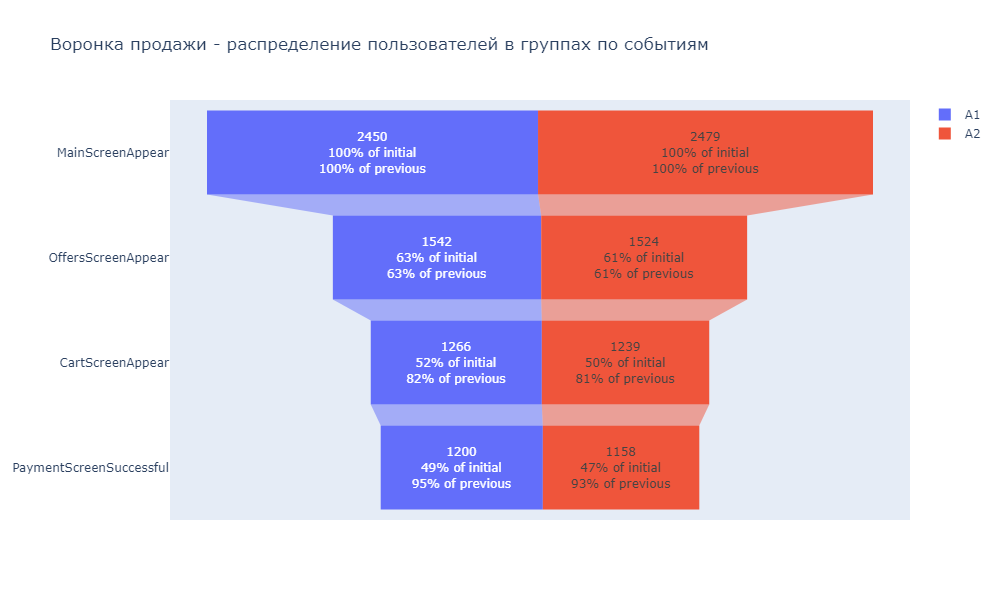

In [43]:
distrib_funnel('A1', 'A2')

Как мы видим, распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже

### Самое популярное событие во всех группах
<a id='14'></a>

In [44]:
#Выведем самое популярное событие
pop_event = list(data_succes.query('A1 == A1.max() and A2 == A2.max() and B == B.max()')['event_name'])
print('Самое популярное событие {}'.format(pop_event))
print()
data_good_event_pop = (
    data_succes.query('event_name == @pop_event')
    [['event_name', 'A1', 'A2', 'B']].set_index('event_name').T
)

data_good_event_pop['perc'] = round(data_good_event_pop['MainScreenAppear'] 
                               / data_good_event_pop['MainScreenAppear'].sum()*100, 2)
print('Количество пользователей в каждой группе, совершивших самое популярное событие')
data_good_event_pop

Самое популярное событие ['MainScreenAppear']

Количество пользователей в каждой группе, совершивших самое популярное событие


event_name,MainScreenAppear,perc
group,,
A1,2450,33.01
A2,2479,33.40
B,2494,33.60


Самое популярное событие во всех группах — посещение главной страницы. Прошлые вычесления показывают, что группы были правильно разделены для групп А1 и А2. Давайте теперь проверим наши гипотезы (нулевую и альтернативную) для пар контрольных и экспериментальной групп

### А1/В эксперимент
<a id='15'></a>

Посмотрим на результаты для первой контрольной группы (А1) и экспериментальной группы (В)

In [45]:
for event in data_succes['event_name'].unique():
    z_test('A1', 'B', event, 0.05)
    print('--------------------------------------------')

Сравнение группы A1 и B события - MainScreenAppear (посещение главного экрана), с критическим уровнем стат значимости 0.05

p-значение:  [0.39691005]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и B события - OffersScreenAppear (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [0.21442477]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и B события - CartScreenAppear (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.08564272]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1 и B события - PaymentScreenSuccessful (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.22753675]
Не получилось отвергнуть нулевую гипотезу, 

Как мы видим, ни для одного события разница не оказалась значимой. Следовательно можно предположить, что для пользователей экспериментальной группы В по отношению к контрольной группе А1 нет достаточной разницы в использовании приложения относительно шрифтов.

Посмотрим на распределение пользователей в обеих группах по событиям, чтобы оценить разбиение на группы. Для этого построим сравнительную воронку продаж по обеим группам

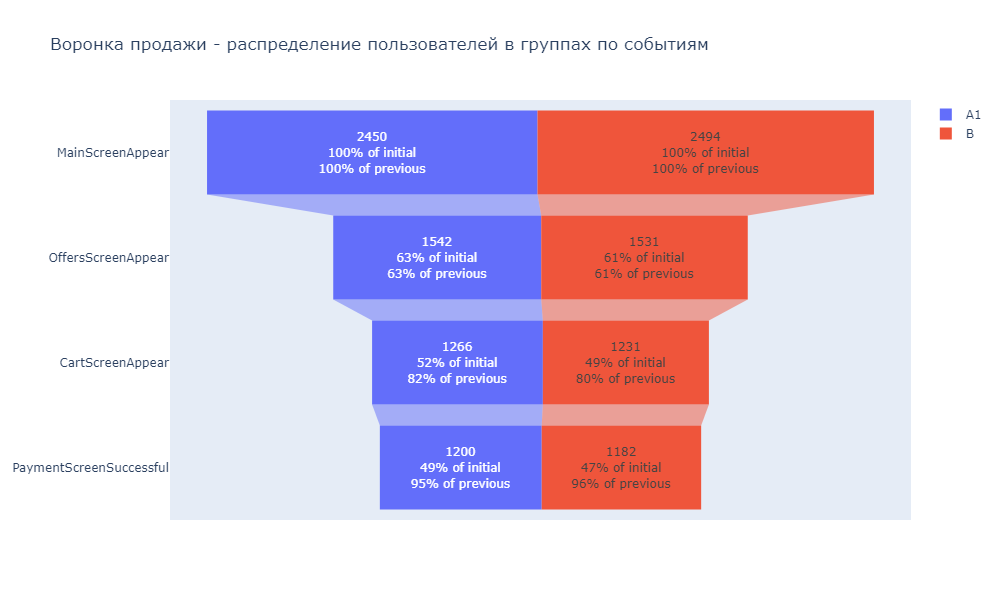

In [46]:
distrib_funnel('A1', "B")

Как мы видим, распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже

### А2/В эксперимент
<a id='16'></a>

Посмотрим на результаты для второй контрольной группы (А2) и экспериментальной группы (В)

In [47]:
for event in data_succes['event_name'].unique():
    z_test('A2', 'B', event, 0.05)
    print('--------------------------------------------')

Сравнение группы A2 и B события - MainScreenAppear (посещение главного экрана), с критическим уровнем стат значимости 0.05

p-значение:  [0.67231677]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A2 и B события - OffersScreenAppear (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [0.89713765]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A2 и B события - CartScreenAppear (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.62645998]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A2 и B события - PaymentScreenSuccessful (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.66803679]
Не получилось отвергнуть нулевую гипотезу, 

Как мы видим, что ни для одного события разница не оказалась значимой, причем значение p_value еще более высокое чем при сравнении прошлых групп. Следовательно можно предположить, что для пользователей экспериментальной группы В по отношению к контрольной группе А2 нет достаточной разницы в использовании приложения относительно шрифтов.

Посмотрим на распределение пользователей в обеих группах по событиям, чтобы оценить разбиение на группы. Для этого построим сравнительную воронку продаж по обеим группам

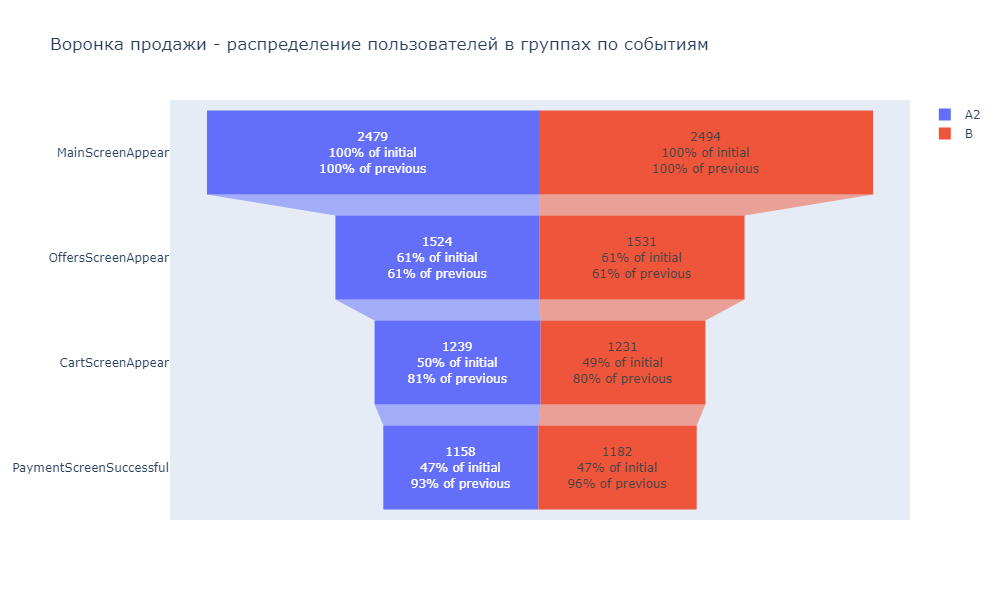

In [48]:
distrib_funnel('A2', 'B')

Как мы видим, распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже

### А1+А2/В эксперимент
<a id='17'></a>

Посмотрим на результаты для объединенной контрольной группы (А1+А2) и экспериментальной группы (В)

In [49]:
for event in data_succes['event_name'].unique():
    z_test('A1+A2', 'B', event, 0.05)
    print('--------------------------------------------')

Сравнение группы A1+A2 и B события - MainScreenAppear (посещение главного экрана), с критическим уровнем стат значимости 0.05

p-значение:  [0.45994688]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1+A2 и B события - OffersScreenAppear (выбор товаров у офферов), с критическим уровнем стат значимости 0.05

p-значение:  [0.43034312]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1+A2 и B события - CartScreenAppear (просмотр корзины), с критическим уровнем стат значимости 0.05

p-значение:  [0.20361356]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------
Сравнение группы A1+A2 и B события - PaymentScreenSuccessful (успешная оплата), с критическим уровнем стат значимости 0.05

p-значение:  [0.65591289]
Не получилось отвергнуть нулеву

In [50]:
#Сравнения закончены, посмотрим на наш список значений p_value
p_value_list

[array([0.67020827]),
 array([0.26673479]),
 array([0.21811884]),
 array([0.10288527]),
 array([0.39691005]),
 array([0.21442477]),
 array([0.08564272]),
 array([0.22753675]),
 array([0.67231677]),
 array([0.89713765]),
 array([0.62645998]),
 array([0.66803679]),
 array([0.45994688]),
 array([0.43034312]),
 array([0.20361356]),
 array([0.65591289])]

Как мы видим, ни для одного события даже объединенной контрольной группы и экспериментальной разница не оказалась значимой. Следовательно можно предположить, что для пользователей нет достаточной разницы в использовании приложений относительно шрифтов.

Посмотрим на распределение пользователей в обеих группах по событиям, чтобы оценить разбиение на группы. Для этого построим сравнительную воронку продаж по обеим группам

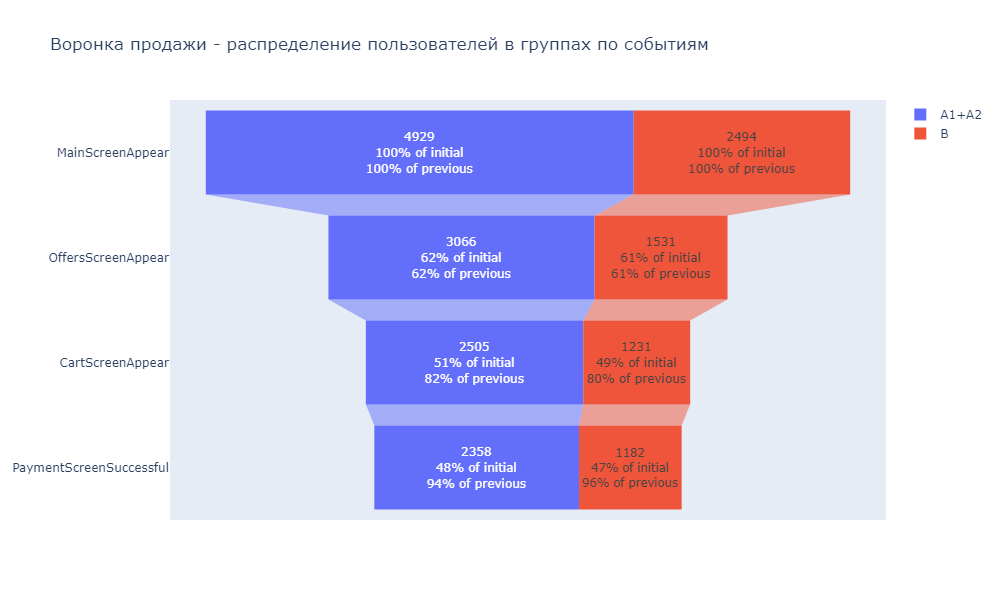

In [51]:
distrib_funnel('A1+A2', 'B')

Как мы видим, распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже

### Вывод после попарных сравнений
<a id='18'></a>

Изначально проверив 2 контрольные группы (А/А эксперимент) выяснили, что ни для одного события разница пропорций не оказалась значимой. Что и должно было получится ведь интерфейс у обеих групп не отличался. Значит действительно можем с уверенностью утверждать что группы А и А2 - контрольные. Также распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже.

Попарно сравнив контрольные и экспериментальную группы на разницу долей, также выяснили, что ни для одного события ни в одной проверке не была найдена существенная статистическая разница между пропорциями. Из этого можно сделалть вывод, что полная смена шрифтов во всем приложении никак не влияет на "поведение" пользователей внутри приложения. Распределение пользователей по группам и доля пользователей переходящих из одного события в другое при всех сравнениях также существенно не отличались.

### Множественные сравнения
<a id='19'></a>

В ходе проверки провели 4 попарных сравнения между группами (по каждому событию):
- между двумя контрольными группами (А/А эксперимент) - А1 и А2
- между первой контрольной группой и экспериментальной - А1 и В
- между второй контрольной группой и экспериментальной - А2 и В
- между скомбинированными контрольными группами и экспериментальной - А1+А2 и В

По итогу было проведено 16 проверок (4 сравнения * 4 события). Из-за большого количество сравнений одних и тех же данных есть вероятность получения ложнопозитивного результата статистического теста. Оценим все полученые нами значения p_value

In [52]:
print('Минимальное значение p_value - {}'.format(pd.Series(p_value_list).min()))
print('Среднее значение p_value - {}'.format(pd.Series(p_value_list).mean()))
print('Максимальное значение p_value - {}'.format(pd.Series(p_value_list).max()))

Минимальное значение p_value - [0.08564272]
Среднее значение p_value - [0.42476432]
Максимальное значение p_value - [0.89713765]


In [53]:
pd.Series(p_value_list)[pd.Series(p_value_list) < 0.1]

6    [0.08564271892834707]
dtype: object

Значение критерия статистической значимости (alpha) - 0,05. Самое минимальное значение p_value в наших сравнениях - около 0,09, что выше выбранного нами критерия alpha. Соответственно при уменьшении alpha наши результаты никак не изменятся и ложнопозитивного результата в нашем случае быть не может. И даже если ставить уровне значимости равным 0,1 - чтобы оценить возможность ложнонегативного результата - наши результаты изменятся только для одной из проверок, так как лишь одно значение немного но меньше 0,1. Соотвественно применять методы корректировки alpha нет смысла.

## Общий вывод
<a id='20'></a>

Нам необходимо было разобраться в поведении пользователей нашего мобильного приложения по продажам продуктов питания, а также исследовать результаты А/А/В эксперимента по изменению шрифтов во всем приложении.

Нами были изучены набор логов пользователей - событий, совершенных пользователями в определенное время в определенной исследовательской группе.

Изучив все данные, были приняты решения:
 - изменить наименование колонок,
 - скорректировать тип данных времени совершения события,
 - удалить 413 дубликатов

В процессе проверки данных мы также выяснили, что нам подходит для анализа не весь представленный изначально диапазон времени с (25 июля 2019 года по 7 августа 2019 года), а лишь данные с 21:00 31 июля 2019 года, так как до этого времени происходил не полный сбор данных. 

По итогу мы потеряли около 1% данных - что ничтожно мало и соотвественно качество наших данных не пострадало и их вполне достаточно для изучения и анализа.

Основные параметры после всех изменений в данных:
 
- Итоговый диапазон времени - с 21:00 31 июля 2019 по 07 августа 2019
- Общее количество событий в логе - 241724
- Общее количество пользователей в логе - 7538

Мы смогли предположить порядок совершения событий пользователями:
1. Пользователь открывает главный экран приложения (большего всего пользователей - 98%), затем
2. Просматривает продукты в каталогах офферов и складывает их в корзину (61% от всех пользователей)
3. Просматривает заполненную корзину и при необходимости корректирует ее (50% от всех пользователей)
4. Успешно оплачивает выбранные товары (47% от всех пользователей)

Почти половина первоначальных пользователей проходят весь путь и доходят до страницы успешной оплаты - 47% всех пользователей, просматривающих главную страницу. Это довольно успешный результат.

Также присутствует событие - просмотр руководства пользователя (пользуется около 11% из всех посетителей). Возможно есть трудности с интерфейсом приложения. Однако это событие непосредственно не влияет на факт успешной оплаты, и поэтому мы исключили его именно из воронки продажи.

Построив воронку продаж мы увидели, что больший процент потери пользователей (38%) происходит при переходе с главного экрана приложения на экран предложения офферов. Это достаточно большой процент потери заинтересованности - возможно:
- присутствует какая то техническая проблема связанная с переходом с главного экрана на экран выбора товаров связанных с определенными мобильными устройствами либо не связанными с ними,
- либо не интуитивно понятный интерфейс главного экрана, что осложняет переход с него на экран выбора товаров - в связи с этим и потребность пользователей заходить на экран руководства пользователя.

В дальнейшем большая часть пользователей "остается с нами":
- 81% от пользователей выбирающих продукты в каталогах - складывают товары в корзину
- 95% пользователей, сформировавших корзину - совершают успешную покупку

Чтобы ответить на вопрос, о необходимости смены шрифтов во всем приложении было проведено А/А/В тестирование. Пользователи были разделены на 3 группы:

- 246 и 247 - контрольные - с изначальными шрифтами (А1 и А2)
- 248 - экспериментальная - с измененными шрифтами (В)

В ходе проверки провели 4 попарных сравнения между группами (по каждому событию):

- между двумя контрольными группами (А/А эксперимент) - А1 и А2
- между первой контрольной группой и экспериментальной - А1 и В
- между второй контрольной группой и экспериментальной - А2 и В
- между скомбинированными контрольными группами и экспериментальной - А1+А2 и В

По итогу было проведено 16 проверок (4 сравнения * 4 события)

Проверку проводили с помощью z-теста (проверка гипотезы о равенстве долей - сравнение пропорций двух генеральных совокупностей по выборкам из них), сравнивая выборки для каждого события - количество пользователей в группе и количество пользователей события в группе

Сформулировали гипотезы:
- Нулевая гипотеза - Нет статистически значимой разницы между группами
- Альтернативная гипотеза - Существует существенная разница между пропорциями в группах

Изначально проверили 2 контрольные группы (А/А эксперимент) (для этого узнали находятся ли статистически значимая разница между выборками А1 и А2 для каждого события) и выяснили, что ни для одного события разница не оказалась значимой. Что и должно было получится ведь интерфейс у обеих групп не отличался. Значит действительно можем с уверенностью утверждать что группы А и А2 - контрольные. Также распределение пользователей по группам и доля пользователей переходящих из одного события в другое в обеих группах схоже.

Далее попарно сравнивали контрольные и экспериментальную группы на разницу долей. И ни для одного события ни в одной проверке не была найдена существенная статистическая разница между пропорциями. Из этого можно сделалть вывод, что полная смена шрифтов во всем приложении никак не влияет на "поведение" пользователей внутри приложения.

Также высянили, что самое популярное событие во всех группах — посещение главной страницы, что естественно для любого мобильного приложения. Пользователи по всем группам и событиям были правильно разделены.
